In [1]:
import pyroomacoustics as pra
from scipy.io import wavfile
import IPython

import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.signal import find_peaks
import scipy

import sys
sys.path.append("src")

from music import *

In [2]:
fs, data = wavfile.read('res/arctic_a0010.wav')
data_variance = np.var(data)
IPython.display.Audio(data, rate=fs)

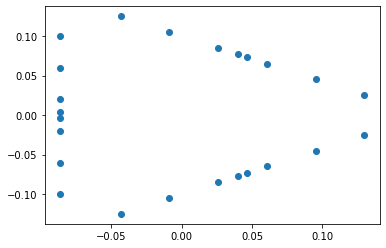

In [3]:
import json

with open('../music_doa/last_year/protocol.json') as json_file:  
    protocol = json.load(json_file)
    
microphone_3D_locations = np.array(protocol['geometry']['microphones']['locations'])
top_mics = np.isclose(microphone_3D_locations[:,2], 0.06123724)
microphone_2D_locations = microphone_3D_locations[top_mics, :2]

plt.scatter(microphone_2D_locations[:, 0], microphone_2D_locations[:, 1])
plt.show()

In [4]:
c = 343.    # speed of sound
# fs = 16000  # sampling frequency
radius=4e-1
mic_distance = 4e-1
start = 4
n_mics = 6

snr_db = 2
distance = 3.  # meters idk wtf is happening
sigma2 = 10.0 * data_variance
wavelength = 1

(<Figure size 432x288 with 1 Axes>, <Axes: >)

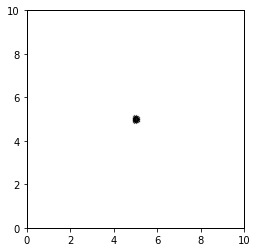

In [5]:
room_dim = np.r_[10.,10.]
aroom = pra.ShoeBox(room_dim, fs=fs, max_order=0, sigma2_awgn=sigma2)

# Adding the microphones

mics_coords = (microphone_2D_locations + room_dim / 2).T
aroom.add_microphone_array(pra.MicrophoneArray(mics_coords, aroom.fs))

aroom.plot()

(<Figure size 432x288 with 1 Axes>, <Axes: >)

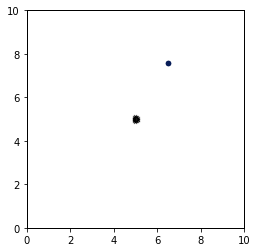

In [6]:
# Add sources of 1 second duration
azimuth = np.array([60]) / 180. * np.pi

rng = np.random.RandomState(23)
duration_samples = 10000

for ang in azimuth:
    random_phase = np.random.uniform(0, 2 * np.pi)
    source_location = room_dim / 2 + distance * np.r_[np.cos(ang), np.sin(ang)]
    aroom.add_source(source_location, signal=data)
    
# Run the simulation
aroom.simulate()
aroom.plot()

In [7]:
IPython.display.Audio(aroom.mic_array.signals[0], rate=fs)

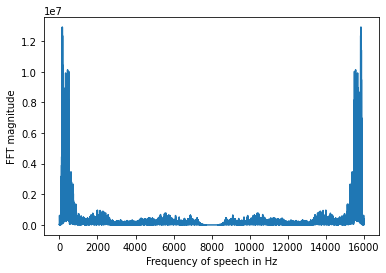

In [8]:
fft = np.fft.fft(data)
frequencies = np.linspace(0, fs, len(fft))

selected_ids = np.argwhere(frequencies < 100000)
selected_freq = frequencies[selected_ids]
selected_fft = fft[selected_ids]

plt.plot(selected_freq, abs(selected_fft))
plt.xlabel("Frequency of speech in Hz")
plt.ylabel("FFT magnitude")
# plt.yscale("log")
plt.show()

Samples shape: (24, 57268)
Covariance shape: (24, 24)


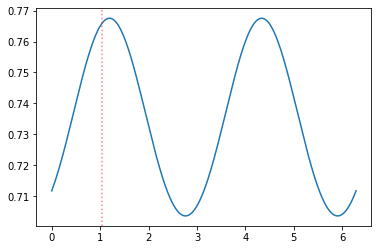

In [9]:
n_sources = len(azimuth)

signal_eigenvalues, signal_eigenvectors, noise_eigenvalues, noise_eigenvectors = music(aroom.mic_array.signals, n_sources)
spectrum = general_spectrum_function(noise_eigenvectors, mics_coords.T, 150)

X = np.linspace(0, 2 * np.pi, 10000)
Y = [spectrum(x) for x in X]

plt.plot(X, Y)
for theta in azimuth:
    plt.axvline(x=theta, color='red', linestyle=':', alpha=0.5)
plt.show()

In [10]:
n_sources = len(azimuth)
seg_duration = 1.0
freq_range=[0, 500]

nperseg = seg_duration * fs
spectrum = music_with_frequency(aroom.mic_array.signals, n_sources, fs, microphone_2D_locations.T, segment_duration=seg_duration, freq_range=freq_range)

Shape of sources STFT: (501, 9, 24)
STFD shape: (24, 24)
Shape of noise eigenvectors: (24, 23)


Extracted frequencies in degrees: [59.832]


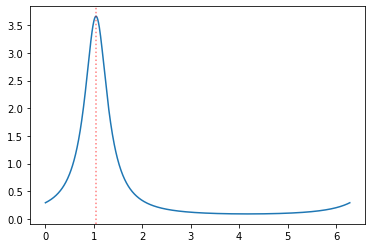

In [11]:
X = np.linspace(0, 2 * np.pi, 1000)
Y = np.array([spectrum(x) for x in X])

plt.plot(X, Y)

for theta in azimuth:
    plt.axvline(x=theta, color='red', linestyle=':', alpha=0.5)

print("Extracted frequencies in degrees:", extract_frequencies(spectrum, n_sources, [0, 2 * np.pi]) * 180 / np.pi)

plt.show()